<a href="https://colab.research.google.com/github/harnalashok/deeplearning-sequences/blob/main/LSTM_time_series_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forecasting
A simple example about how to use LSTM for making predictions

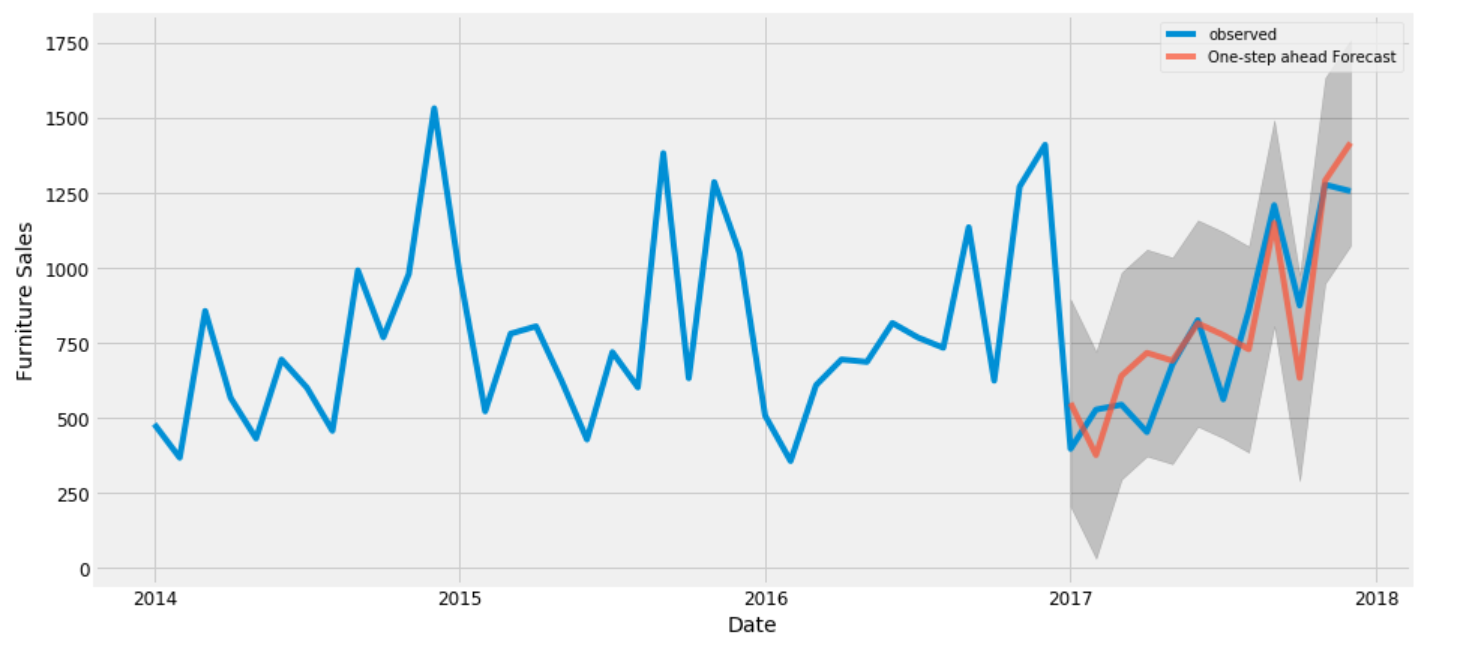

In [ ]:
"""
Last amended: 18th Sep, 2021
Myfolder: 		/home/ashok/Documents/12. time_series_data
Datafolder:		/home/ashok/.keras/datasets/airlines_timeseries_data

Ref: 
    https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
    https://towardsdatascience.com/using-lstms-to-forecast-time-series-4ab688386b1f


Objective:  
            Predict one-dimensional timeseries data
"""

## Call libraries

In [ ]:
# 1. Call libraries
%reset -f
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1.1 Keras models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import LSTM

# 1.2 sklearn libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# 1.3 Misc (for RMSE etc)
import math, os

In [ ]:
# 1.4 Display multiple command outputs from a cell:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Mount Google Drive

In [ ]:
# 1.5
from google.colab import drive
drive.mount('/content/gdrive')

## Read Data and plot

In [ ]:

################## Data reading ############################

# Data ingestion and processing
# 2.0 
pathToData = "/content/gdrive/MyDrive/Colab_data_files/time_series/international-airline-passengers.csv.zip"
#os.chdir(pathToData)

# 2.1 Read data
dataframe = pd.read_csv(pathToData,
	                      compression='infer', 
	                      usecols=[1],
                        encoding="ISO-8859-1"      # 'utf-8' gives error, hence the choice
                        )

In [ ]:
# 2.2 Plot data
plt.plot(dataframe) ;
plt.show() ;

## Data normalization

In [ ]:
# 3.0 Normalize the dataset.
#     We will also use the scaler later for inverse_transform
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataframe)

# 3.1 Examine:
print(dataset[:5])
print(dataset.shape)   # Shape is (144,1)

## Split dataset

In [ ]:
# 3.2 Data splitting
#      Get sizes:

train_size = int(len(dataset) * 0.67) 
test_size = len(dataset) - train_size

# 3.2.1
print(train_size)
print(test_size)

In [ ]:
# 3.3 Split into train and test sets in 67% and 33%

train = dataset[0:train_size,:]
test  = dataset[train_size:len(dataset),:]
len(train), len(test)

In [ ]:
# 3.4 Have a look:

print(train.shape)    # (96,1)
print(train[:3])

## Preparing train/test data
For input to LSTM model, we need to prepare train and test data in a special way

Assume the following is our timeseries data. Then we have to decide how many timesteps of past data (lookback) will be used to predict the next timestep. Note we are talking of just one time step of prediction in future using multiple time-steps from past. (Incidentally, for multiple timesteps of predictions in future, we need an Encoder/Decoder type of network.)


Our time series:

```
index-->  0    1    2    3    4    5    6    7
values-> 23   25   14   13   16   18   20   21
```
Here is how, I will prepare (X,y) data for injecting into model:

>If lookback is 2, then I start at 0th Index. Read two elements (at index 0 & 1) as X and read the 3rd element (at index 2) as y. Increment index by 1. Go on like this till I reach at 5th index. ie finsh at range(len(data) - lookback) or range(8-2) ie 0,1,2,3,4,5. Our final data should be as below:

```
X = np.array([
               [23,25],            # This is X[0]
               [25,14],            # This is X[1]
               [14,13],
                  |
                  |
             ]   
            )


y = np.array([14,13,16....])

```           

In [ ]:
# 5. We define a function to create a new dataset
#    The function takes two arguments: the dataset,
#    which is a NumPy array that we want to convert
#    into two datasets, dataset and the look_back,
#    which is the number of previous time steps to 
#    use as input variables to predict the next time
#    period — in this case defaulted to 1.

#    We create a dataset where trainX is the number
#    of passengers at a given time (t) and trainY is the
#    number of passengers at the next time (t + 1).
#    If lookback is 2, I should get:
#        X= d[0],d[1]    Y = d[2]
#        X= d[92],d[93]  Y = d[94]

# 5.1 Convert an array of values into a dataset matrix:

def create_dataset(data, look_back=1): 

  # 5.1.1 Create two blank lists          
	dataX, dataY = [], []                             

  # 5.1.2                                                    
	for i in range(len(data)-look_back):              
		a = data[i:(i+look_back), 0]                    
		dataX.append(a)                  # [[23,25]]

		b = data[i + look_back, 0]                      
		dataY.append(b)                  # [14]                           
  
  # 5.1.3
	return np.array(dataX), np.array(dataY)   



In [ ]:
# 6.0 Check if it meets our task. Prepare data first:

data = np.array([23,25,14,13,16,18,20,21]).reshape(-1,1)
data

In [ ]:
# 6.1 Apply function:

lookback =1
X,y = create_dataset(data,lookback)

print(X)
print(y)

In [ ]:
# 6.1 Apply function:

lookback = 2
X,y = create_dataset(data,lookback)

print(X)
print(y)

In [ ]:
# 7.0 Get our X and Y now for train data:

look_back = 1              #  Try 2
trainX, trainY = create_dataset(train, look_back)

In [ ]:
# 7.1 Get our X and Y now for test data:

testX, testY   = create_dataset(test, look_back)

In [ ]:
# 7.2 See few points at the beginning:

print(trainX[:3])
print(trainY[:3])

## Begin Modeling

### Reshape trainX/testX data

In [ ]:
# 8.0 Reshape input to be [samples, timesteps, NoOfFeatures]
#     What does each mean? See detailed note at the end of this code:

trainX = np.reshape(
                     trainX,
                     (trainX.shape[0], 1, trainX.shape[1])
                    )

# 8.0.1
testX = np.reshape(
                     testX,
                     (testX.shape[0], 1, testX.shape[1])
                     )

# 8.1 Check
trainX.shape             # (95,1,1)    ndarray
testX.shape              # (47,1,1)    ndarray
trainY.shape             # (95,)       ndarray
testY.shape              # (47,)       ndarray

### Design Model

In [ ]:
# 9. Create and fit the LSTM network
#    t+1 is being predicted based on t
#    1) LSTM with 4 neurons in the first visible layer
#    2) dropout 20%
#    3) 1 neuron in the output layer for predicting no_of_passengers
#    4) The input shape will be 1 time step with 1 feature (look_back).
#    5) I use the Mean Squared Error (MSE) loss function and the efficient Adam version of stochastic gradient descent.
#    6) The model will be fit for 100 training epochs with a batch size of 70


model = Sequential()

# 9.1
model.add(
           LSTM(
                4,
                input_shape=(1, look_back)
                )
           )     # Use default activation functions

#model.add(Dropout(0.2))

# 9.2 Classification layer:
model.add(
            Dense(
                 1,
                  activation='sigmoid'
                  )
          )


In [ ]:
# 9.3
model.summary()

In [ ]:
# 9.4 Compile:

model.compile(
                loss='mean_squared_error',
                optimizer='adam'
              )

### Fit model

In [ ]:
# 9.5 Fit the model:

model.fit(
          trainX,
          trainY,
          epochs=100,
          batch_size=1,
          verbose=2
          )

## Make predictions and plot

In [ ]:
# 10. Make predictions for train data itself: 

trainPredict = model.predict(trainX)

In [ ]:
# 10.1 Reshape trainX into 1D array:

X = trainX.reshape(trainX.shape[0],)
len(X)

In [ ]:
# 10.2 Reshape predictions of trainX data:

y = trainPredict.reshape(trainPredict.shape[0],)
len(y)

In [ ]:
# 10.3 X 'tomorrow' is to be compared with y 'today' :
#  
X = X[1:]
y = y[:-1]

# 10.4 Just check if lengths are equal:

len(X), len(y)

In [ ]:
# 10.4 Now plot both X and y:

plt.plot(X) ;
plt.plot(y) ;

In [ ]:
# 11. Make predictions for testX data:

testPredict = model.predict(testX)
X1 = testX.reshape(testX.shape[0],)
y1 = testPredict.reshape(testPredict.shape[0],)

# 11.1
X1 = X1[1:]
y1 = y1[:-1]

# 11.2 Plot now:
plt.plot(X1) ;
plt.plot(y1) ;

## Scale back both X and y components of trainX and textX


In [ ]:
# 12. Invert predictions (rescale back using learned scaler)
#     And actual values
trainPredict = scaler.inverse_transform(X.reshape(-1,1))
print(trainPredict[:3])
testPredict = scaler.inverse_transform(X1.reshape(-1,1)) 
print(testPredict[:3])

In [ ]:

# 13. Similar actions on test data
testPredict = scaler.inverse_transform(testPredict)
rescaled_testY = scaler.inverse_transform([testY])


## Evaluate predictions

In [ ]:

# 14. Calculate root mean squared error
trainPredict[:, 0].shape           # Predicted values
rescaled_trainY[0].shape           # Actual values
trainScore = math.sqrt(mean_squared_error(rescaled_trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(rescaled_testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))



(95,)

(95,)

Train Score: 109422.95 RMSE
Test Score: 210862.70 RMSE


## ======================== MISC ==================================================

In [ ]:

# 10. Shift train predictions for plotting
#     While plotting what is to be kept in mind
#      is that very first prediction at array-index 0
#       is for the actual value of train data t+lookback periods
#        in future
trainPredictPlot = np.empty_like(dataframe.values)       # Return a new array with the same shape and type as a given array.
trainPredictPlot[:, :] = np.nan                 # dataset.shape: (144,1)
trainPredictPlot.shape                          # (144,1)
trainPredictPlot


In [ ]:

# 10.1 As trainPredict is the value of data in future ie at
#       at t+1 (given t), it has to be plotted/compared with
#       actual value (at the time).
#        Therefore, to compare prediction with actually what took place
#          we have to shift the predictions to right by look_back.
#            So value of trainPredict at index 0, is actually
#             to be compared with value of train data at index 1
#              ie index 'look_back' ahead.
trainPredictPlot[look_back:(len(trainPredict)+look_back), :] = trainPredict
trainPredictPlot[:10]          # Note one nan at the very beginning as a result of 'push-down'
trainPredict[:10]



In [ ]:

# 11. Shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan


In [ ]:

# 11.1  testPredict starts where trainPredict ended ie len(trainPredict)+look_back
#       So start is: len(trainPredict)+look_back +1
#       And each prediction shifted to right by look_back
testPredictPlot[((len(trainPredict)+look_back +1) + look_back) :len(dataframe.values)-1, :] = testPredict
testPredictPlot    # First value will be not nan


# 12. Plot baseline and predictions
plt.plot(scaler.inverse_transform(dataframe.values))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


In [ ]:
###############################